## Importing the required libraries

In [21]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [22]:
from keras import regularizers

In [23]:
import os

In [24]:
mylist= os.listdir('RawData/')

In [25]:
type(mylist)

list

In [26]:
len(mylist)

1440

01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

In [27]:
print(mylist[1000])

03-01-06-02-01-02-17.wav


In [28]:
print(mylist[1000][6:-16])

06


## Plotting the audio file's waveform and its spectrogram

In [29]:
data, sampling_rate = librosa.load('RawData/03-01-06-02-01-02-17.wav')

Populating the interactive namespace from numpy and matplotlib


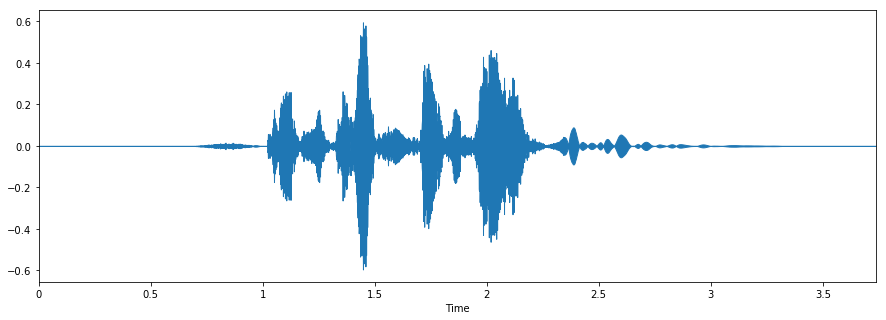

In [30]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

C:\Program Files\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in log


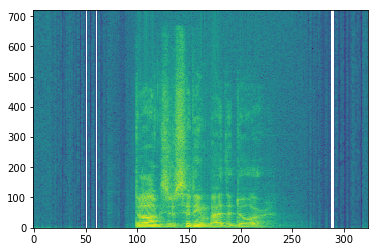

In [31]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-02-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

## Setting the labels

In [33]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    if item[6:-16]=='01' and int(item[18:-4])%2==0:
        feeling_list.append('female_neutral')
    elif item[6:-16]=='01' and int(item[18:-4])%2==1:
        feeling_list.append('male_neutral')
    if item[6:-16]=='07' and int(item[18:-4])%2==0:
        feeling_list.append('female_disgust')
    elif item[6:-16]=='07' and int(item[18:-4])%2==1:
        feeling_list.append('male_disgust')
    if item[6:-16]=='08' and int(item[18:-4])%2==0:
        feeling_list.append('female_surprised')
    elif item[6:-16]=='08' and int(item[18:-4])%2==1:
        feeling_list.append('male_surprised')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    #elif item[:1]=='a':
     #   feeling_list.append('male_angry')
    #elif item[:1]=='f':
     #   feeling_list.append('male_fearful')
    #elif item[:1]=='h':
    #    feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    #elif item[:2]=='sa':
     #   feeling_list.append('male_sad')

In [34]:
labels = pd.DataFrame(feeling_list)

In [35]:
labels[:10]

,0
0,male_neutral
1,female_neutral
2,male_neutral
3,female_neutral
4,male_neutral
5,female_neutral
6,male_neutral
7,female_neutral
8,male_neutral
9,female_neutral


## Getting the features of audio files using librosa

In [36]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [37]:
df[:5]

,feature
0,"[-70.2677641611, -70.2677641611, -70.267764161..."
1,"[-65.7076524007, -65.7076524007, -63.114722422..."
2,"[-65.4824988827, -65.4824988827, -65.482498882..."
3,"[-64.5284491035, -64.5284491035, -64.528449103..."
4,"[-62.3643105275, -59.9347251381, -61.869599961..."


In [38]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [39]:
newdf = pd.concat([df3,labels], axis=1)

In [40]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [41]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.082741,-60.234652,male_neutral
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.144064,-48.705645,female_neutral
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.323644,-40.710780,male_neutral
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.610100,-44.698259,female_neutral
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.383777,-43.965398,male_neutral


In [42]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
522,-55.102562,-56.048294,-58.384500,-61.521559,-64.581595,-64.264367,-63.681615,-61.965197,-63.487459,-64.640674,...,-51.864803,-52.473707,-51.908845,-54.379388,-53.660037,-53.956100,-52.871700,-51.789471,-52.396382,male_sad
283,-65.935606,-65.935606,-65.935606,-65.935606,-65.935606,-65.935606,-65.935606,-65.935606,-65.935606,-65.935606,...,-63.968357,-62.205670,-63.053774,-63.764809,-62.634020,-63.911225,-64.807913,-62.783637,-63.491862,female_calm
991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_fearful
544,-50.397211,-50.370851,-52.172658,-52.218375,-51.204145,-49.076029,-48.178180,-48.871602,-46.627349,-47.024000,...,-34.744759,-33.950301,-33.144540,-31.738124,-31.705401,-32.861880,-37.025880,-32.241703,-26.728261,male_sad
184,-54.251546,-53.747044,-54.013879,-55.495179,-54.903676,-52.443804,-52.414411,-51.790750,-50.408602,-52.702740,...,-52.463201,-50.609731,-49.431685,-50.167981,-51.400662,-54.994406,-51.982826,-50.560819,-53.692352,male_calm
1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_surprised
1012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_fearful
837,-46.549754,-49.894717,-52.149974,-53.195930,-53.348468,-52.534322,-51.635080,-50.806060,-49.999857,-50.401288,...,-49.673718,-48.065058,-48.738222,-52.110374,-53.139163,-53.865706,-51.622978,-51.382256,-52.000805,female_angry
284,-58.416270,-58.416270,-58.416270,-57.573445,-57.402440,-58.283530,-59.001954,-55.797078,-58.000678,-56.934552,...,-35.375331,-36.822361,-40.088500,-37.593660,-38.732343,-40.107168,-41.780195,-41.634849,-42.437048,male_calm
700,-46.696664,-46.092927,-46.639220,-47.010025,-47.230564,-47.697537,-47.697537,-47.697537,-47.697537,-47.697537,...,-45.065878,-44.751488,-44.250486,-45.001233,-42.661334,-43.193026,-43.266707,-43.577317,-45.003344,male_angry


In [43]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [44]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [45]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
812,-57.058829,-57.144099,-55.631681,-55.082801,-53.683282,-52.560012,-52.662414,-52.647138,-52.460894,-53.516815,...,-37.095173,-39.142991,-40.312040,-40.335559,-44.034906,-44.490622,-46.068601,-47.309970,-50.974731,male_angry
822,-58.545328,-59.202478,-60.137033,-62.037020,-62.147955,-61.235847,-61.505283,-61.574950,-61.505381,-60.495135,...,-62.534837,-63.489974,-63.011312,-60.754591,-60.942248,-61.236054,-61.601959,-60.400122,-60.975515,male_angry
83,-53.552852,-52.381307,-49.825081,-50.466629,-54.859334,-57.549736,-59.093294,-57.289919,-57.218038,-58.383245,...,-50.852087,-52.688179,-54.263841,-53.873908,-57.603321,-59.374006,-58.332527,-57.452695,-58.009607,female_neutral
130,-63.666725,-61.242559,-60.202072,-60.961954,-61.256631,-60.524265,-60.206617,-61.908236,-64.984077,-68.658365,...,-54.575644,-54.653415,-50.194249,-51.969966,-53.515084,-53.341371,-54.337876,-53.027439,-56.124581,male_calm
687,-45.452771,-45.452771,-45.452771,-45.452771,-45.452771,-45.452771,-45.452771,-45.452771,-45.452771,-45.452771,...,-28.229852,-27.947973,-26.114508,-25.313421,-27.437429,-29.881019,-34.044767,-33.245406,-29.589436,female_angry
669,-55.490920,-54.413760,-52.647229,-51.409487,-52.615997,-50.656469,-49.831283,-50.206940,-50.343438,-49.998324,...,-33.229618,-32.631736,-31.708020,-31.251413,-32.065469,-31.903136,-31.957088,-29.079692,-25.029768,female_sad
1171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_disgust
1013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_fearful
242,-54.514621,-54.514621,-54.514621,-54.525965,-54.537466,-54.706125,-54.679491,-54.554764,-54.514621,-54.517322,...,-47.733217,-49.022970,-49.438363,-48.091654,-46.473150,-45.532717,-43.895546,-47.092912,-49.495196,male_calm
509,-69.459008,-69.451640,-68.840078,-69.228567,-68.105873,-66.812655,-67.263511,-68.969079,-67.278665,-67.232089,...,-52.635816,-53.371605,-52.580358,-52.301818,-53.280595,-51.640529,-52.419254,-49.779515,-45.069883,female_sad


In [46]:
trainfeatures = train.iloc[:, :-1]

In [47]:
trainlabel = train.iloc[:, -1:]

In [48]:
testfeatures = test.iloc[:, :-1]

In [49]:
testlabel = test.iloc[:, -1:]

In [50]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
y_train

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [52]:
X_train.shape

(1144, 216)

## Changing dimension for CNN model

In [53]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [54]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

In [87]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [88]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=2, validation_data=(x_testcnn, y_test))

Train on 1144 samples, validate on 296 samples
Epoch 1/2
1144/1144 [==============================] - 23s 20ms/step - loss: 2.7250 - acc: 0.1294 - val_loss: 2.6168 - val_acc: 0.1250

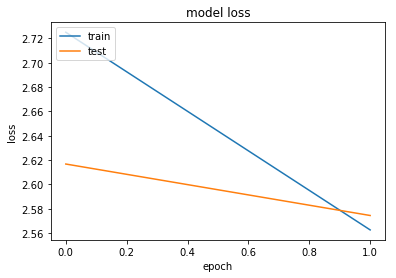

In [89]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [90]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\ABHAGAM\Downloads\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [91]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [92]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 13.51%


## Predicting emotions on the test data

In [93]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

296/296 [==============================] - 3s 10ms/step


In [94]:
preds

array([[ 0.10858649,  0.14429557,  0.00360896, ...,  0.04029438,
         0.07173084,  0.00470781],
       [ 0.06226503,  0.0622882 ,  0.06282116, ...,  0.06229123,
         0.06232814,  0.06265029],
       [ 0.10902756,  0.10543889,  0.00592806, ...,  0.04592827,
         0.08735404,  0.00530129],
       ..., 
       [ 0.06226503,  0.0622882 ,  0.06282116, ...,  0.06229123,
         0.06232814,  0.06265029],
       [ 0.10266724,  0.11598716,  0.00428999, ...,  0.04058108,
         0.10117512,  0.00456688],
       [ 0.09650806,  0.10365073,  0.00733358, ...,  0.05138187,
         0.0901894 ,  0.00615409]], dtype=float32)

In [95]:
preds1=preds.argmax(axis=1)

In [96]:
preds1

array([ 1, 10,  8, 10,  8,  1,  8,  8, 10,  1,  8,  8, 10,  8,  8, 10,  0,
        8, 10, 10, 10, 12,  8, 10, 12,  8, 10,  1, 10, 10, 10,  6,  0,  1,
        1,  8, 10,  8, 10,  8,  1,  1,  4,  0,  8,  8,  8,  1, 10,  6,  1,
        8, 10,  8,  8, 10,  0,  0,  8, 10,  1, 10,  8, 10, 10,  8,  1,  1,
        1, 10, 10,  4,  0, 10,  8,  1,  1,  0, 10,  8, 10, 10,  1,  0,  1,
        8, 10, 10, 10, 10,  1, 10,  0, 10,  8,  1, 10,  1,  1,  0,  4,  1,
       10,  4,  1,  1, 10, 10,  8,  8, 10,  8, 10,  1,  4,  8, 12,  1,  1,
       10,  8,  4, 10, 10,  8,  1, 10, 10,  1,  8, 10,  1,  1, 10,  1, 12,
        8,  6,  1,  0,  1, 10,  4, 10,  1,  1,  8,  8,  8, 10,  8,  8,  8,
       10,  8,  1, 10,  8, 10, 10,  1,  1,  8,  1,  1, 10,  0, 10,  1,  8,
        8,  0,  0,  8, 10, 10, 10,  1, 10,  4,  8,  0,  8, 10,  1,  0, 10,
        0,  8,  8,  8,  0,  8, 10, 10,  1,  8,  0,  0,  1,  0,  1, 10,  0,
        1,  8, 10,  1,  8,  0,  8,  1,  1,  8,  8,  1,  6,  1,  8,  1,  1,
       10,  8,  8, 10, 10

In [97]:
abc = preds1.astype(int).flatten()

In [98]:
predictions = (lb.inverse_transform((abc)))

In [99]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_calm
1,male_disgust
2,male_angry
3,male_disgust
4,male_angry
5,female_calm
6,male_angry
7,male_angry
8,male_disgust
9,female_calm


In [100]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [101]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_sad
1,female_fearful
2,male_calm
3,male_surprised
4,male_sad
5,male_sad
6,male_happy
7,male_calm
8,female_disgust
9,male_sad


In [102]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [103]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_neutral,male_angry
171,female_angry,female_angry
172,female_fearful,female_angry
173,male_fearful,male_angry
174,male_disgust,male_disgust
175,female_disgust,male_disgust
176,female_surprised,male_disgust
177,female_happy,female_calm
178,female_disgust,male_disgust
179,male_fearful,female_happy


In [104]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,15
female_calm,16
female_disgust,25
female_fearful,21
female_happy,16
female_neutral,4
female_sad,24
female_surprised,17
male_angry,21


In [105]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,29
female_calm,76
female_happy,11
female_sad,5
male_angry,80
male_disgust,90
male_happy,5


In [106]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [107]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


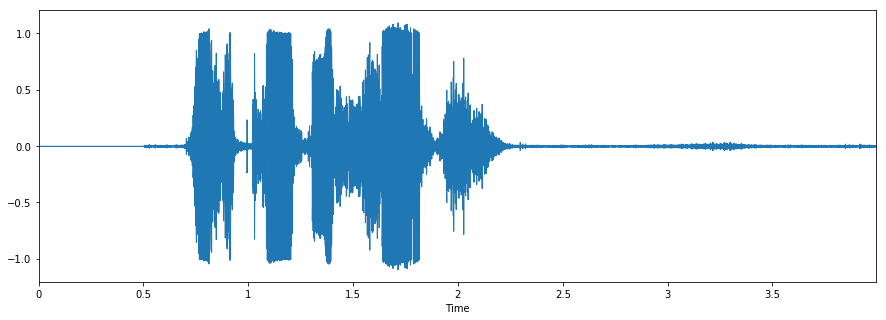

In [108]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [109]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [110]:
livedf2= pd.DataFrame(data=livedf2)

In [111]:
livedf2 = livedf2.stack().to_frame().T

In [112]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [113]:
twodim= np.expand_dims(livedf2, axis=2)

In [114]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 14ms/step


In [115]:
livepreds

array([[ 0.08122849,  0.10006452,  0.02074698,  0.0796276 ,  0.08217862,
         0.05720783,  0.07203379,  0.02495855,  0.07525494,  0.09095141,
         0.02679174,  0.04956218,  0.07661318,  0.04919014,  0.09542996,
         0.01816014]], dtype=float32)

In [116]:
livepreds1=livepreds.argmax(axis=1)

In [117]:
liveabc = livepreds1.astype(int).flatten()

In [118]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_calm'], dtype=object)

In [119]:
liveabc

array([1])